# Transfer learning and fine tuning with MobileNet_V2 using sample dataset 1.

Baseline model MobileNet on sample.

In [ ]:
import os
import gdown
import shutil
import numpy as np
import pandas as pd
import pathlib
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Model
from tensorflow.keras.utils import save_img, img_to_array, array_to_img, load_img, image_dataset_from_directory
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.regularizers import l2
from tensorflow.keras.metrics import Recall, Precision
from tensorflow.keras.utils import plot_model
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [ ]:
IS_COLAB = "google.colab" in str(get_ipython())

if IS_COLAB:
    small_data_dir = pathlib.Path("/content/content/small_subset")
else:
    # import os
    small_data_dir = pathlib.Path(os.getcwd()) / "Source/content/small_subset"

In [ ]:
!pip install wandb

In [ ]:
import wandb
wandb.login()

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: syurt (syurt-institution) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [ ]:
wandb.init(project='melanoma_classification', settings=wandb.Settings(code_dir=None))
from wandb.integration.keras import WandbMetricsLogger, WandbModelCheckpoint

In [ ]:
os.environ["WANDB_MODE"] = "dryrun"
os.environ["WANDB_DIR"] = "/dev/null"
os.environ["WANDB_DATA_DIR"] = "/dev/null"
os.environ["WANDB_CONFIG_DIR"] = "/dev/null"

In [ ]:
def show_dirs_len(path):
  for root, dirs, _ in os.walk(path):
    print(f"{os.path.relpath(root, path)}: {len(os.listdir(root))}")

## Формування робочого датасету

Завантаження джерела

In [ ]:
# https://drive.google.com/file/d/1kkJoL40OW9PfgEMtFkmyHAJWN7BVs_ee/view?usp=sharing
file_id = "1kkJoL40OW9PfgEMtFkmyHAJWN7BVs_ee"
url = f"https://drive.google.com/uc?id={file_id}"
output = "2020_supplemented.zip"

gdown.download(url, output, quiet=False)


Downloading...
From (original): https://drive.google.com/uc?id=1kkJoL40OW9PfgEMtFkmyHAJWN7BVs_ee
From (redirected): https://drive.google.com/uc?id=1kkJoL40OW9PfgEMtFkmyHAJWN7BVs_ee&confirm=t&uuid=e106f421-bff0-4ca5-964d-737b0bc3ba2b
To: /content/2020_supplemented.zip
100%|██████████| 1.59G/1.59G [00:22<00:00, 69.7MB/s]


'2020_supplemented.zip'

In [ ]:
!unzip -q 2020_supplemented.zip

In [ ]:
data_dir = "/content/2020_supplemented"

In [ ]:
show_dirs_len(data_dir)

.: 2
train: 2
train/melanoma: 5093
train/other: 32112
test: 2
test/melanoma: 1587
test/other: 10638


In [ ]:
# shutil.rmtree("/content/2020_supplemented")

Функції для виділення з тренувального набору валідаційного, створення вибірки датасету потрібного розміру.

In [ ]:
def make_sructured_subset(rate, source_path, dest_path, my_seed, copy=True):

  """create folder the same structure as source
     with of content files"""
  np.random.seed(my_seed)
  for root, dirs, files in os.walk(source_path):
    relative_path = os.path.relpath(root, source_path)
    new_folder = os.path.join(dest_path, relative_path)
    os.makedirs(new_folder, exist_ok=True)
    if files:
      num_files = int(len(files)*rate)
      files_to_copy = np.random.choice(files, num_files, replace=False)

      for filename in files_to_copy:
        src_file = os.path.join(root, filename)
        dest_file = os.path.join(new_folder, filename)
        if copy:
          shutil.copyfile(src_file, dest_file)
        else:
          shutil.move(src_file, dest_file)

In [ ]:
def make_balanced_sructured_subset(source_path, dest_path, my_seed, rates_per_class, copy=True):

  """create folder the same structure as source
     with part of content files, picked using different rate for selected folder:
      rate*k"""
  np.random.seed(my_seed)
  for root, dirs, files in os.walk(source_path):
    relative_path = os.path.relpath(root, source_path)
    class_name = os.path.basename(relative_path)
    if class_name in rates_per_class:
       rate = rates_per_class[class_name]
    else:
      rate = 0.2
    new_folder = os.path.join(dest_path, relative_path)
    os.makedirs(new_folder, exist_ok=True)
    if files:
      num_files = int(len(files)*rate)
      files_to_copy = np.random.choice(files, num_files, replace=False)

      for filename in files_to_copy:
        src_file = os.path.join(root, filename)
        dest_file = os.path.join(new_folder, filename)
        if copy:
          shutil.copyfile(src_file, dest_file)
        else:
          shutil.move(src_file, dest_file)

In [ ]:
def make_custom_sructured_subset(source_path, dest_path, my_seed, rates_per_ds, copy=True):

  """create folder the same structure as source
     with % of source folder files, randomly picked
     using different rate for each ds"""
  np.random.seed(my_seed)
  for root, dirs, files in os.walk(source_path):
    relative_path = os.path.relpath(root, source_path)
    new_folder = os.path.join(dest_path, relative_path)
    os.makedirs(new_folder, exist_ok=True)
    if files:
      for ds in rates_per_ds.keys():
        if ds in new_folder.split(os.sep):
          rate = rates_per_ds[ds]
          break
      num_files = int(len(files)*rate)
      files_to_copy = np.random.choice(files, num_files, replace=False)

      for filename in files_to_copy:
        src_file = os.path.join(root, filename)
        dest_file = os.path.join(new_folder, filename)
        if copy:
          shutil.copyfile(src_file, dest_file)
        else:
          shutil.move(src_file, dest_file)

In [ ]:
# select in validation directory equal size of classes
val_dir = data_dir + "/validation"
train_dir = data_dir + "/train"
num_melanoma = len(os.listdir(os.path.join(train_dir, "melanoma")))
num_other = len(os.listdir(os.path.join(train_dir, "other")))
k = num_melanoma/num_other if num_other > 0 else 1
print(k)
rates_per_class = {
    "melanoma": 0.2,
    "other": 0.2*k
}
make_balanced_sructured_subset(train_dir, val_dir, 10, rates_per_class, copy=False)

0.15860114598903838


In [ ]:
show_dirs_len(data_dir)

.: 3
train: 2
train/melanoma: 4075
train/other: 31094
test: 2
test/melanoma: 1587
test/other: 10638
validation: 2
validation/melanoma: 1018
validation/other: 1018


In [ ]:
# select different proportion for train, valid and test datasets in small subset
subset_path = "/content/small_subset"
rates_per_ds = {
    "train": 0.3,
    "validation": 1.0,
    "test": 0.7,
}
make_custom_sructured_subset(data_dir, subset_path, 10, rates_per_ds)

In [ ]:
show_dirs_len(subset_path)

.: 3
train: 2
train/melanoma: 1222
train/other: 9328
test: 2
test/melanoma: 1110
test/other: 7446
validation: 2
validation/melanoma: 1018
validation/other: 1018


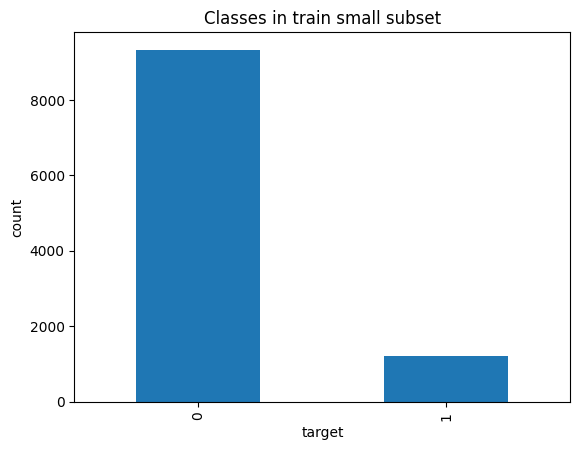

In [ ]:
tmp_df1 = pd.DataFrame({"image_name": os.listdir(subset_path + "/train/melanoma"), "target": 1})
tmp_df2 = pd.DataFrame({"image_name": os.listdir(subset_path + "/train/other"), "target": 0})
tmp_df_comb = pd.concat([tmp_df1, tmp_df2], ignore_index=True)
tmp_df_comb.target.value_counts().plot(kind='bar')
plt.title('Classes in train small subset')
plt.xlabel('target')
plt.ylabel('count')
plt.show()

## Аугментація цільового класу для збалансування набору

In [ ]:
data_augmentation = keras.Sequential(
    [ layers.RandomFlip(mode="horizontal_and_vertical"),
      layers.RandomRotation(0.5),
      layers.RandomZoom(0.3),
      layers.RandomShear(x_factor=0.2, y_factor=0.2, fill_mode="nearest"),
      # layers.MixUp(alpha=0.2),
      layers.RandomColorJitter(
          value_range=(0, 255),
          brightness_factor=0.1,
          contrast_factor=0.1,
          saturation_factor=(0.46, 0.54),
          hue_factor=0.05)
    ]
)

In [ ]:
def augment_and_save(img_path, data_augmentation, num_aug, save=True, output_dir=None):
  aug_images_set =[]
  img = load_img(img_path)
  img_arr = img_to_array(img)
  img_arr = np.expand_dims(img_arr, axis=0)  # додати розмірність - batch
  for i in range(num_aug):
    augmented_img_arr = data_augmentation(img_arr, training=True)
    # augmented_img = keras.utils.array_to_img(augmented_img_arr[0])
    augmented_img = array_to_img(augmented_img_arr[0])   #first in batch
    aug_images_set.append(augmented_img)
    if save:
      os.makedirs(output_dir, exist_ok=True)
      img_name = os.path.basename(img_path)
      output_path = os.path.join(output_dir, f"{os.path.splitext(img_name)[0]}_aug_{i}.jpg")
      save_img(output_path, augmented_img)
  return aug_images_set

def run_augmentation(data_augmentation, input_dir, output_dir, num_aug):
  for img_name in os.listdir(input_dir):
    if img_name.endswith((".png", ".jpg", ".jpeg")):
      img_path = os.path.join(input_dir, img_name)
      augment_and_save(img_path, data_augmentation, num_aug, save=True, output_dir=output_dir)

def run_selective_augmentation(data_augmentation, input_dir, output_dir, num_aug, ratio=0.3, my_seed=42):
  """augmentation of subset"""
  np.random.seed(my_seed)
  images = os.listdir(input_dir)
  images_to_augm = np.random.choice(images, len(images)*ratio, replace=False)
  for img_name in images:
    if img_name.endswith((".png", ".jpg", ".jpeg")):
      img_path = os.path.join(input_dir, img_name)
      augment_and_save(img_path, data_augmentation, num_aug, save=True, output_dir=output_dir)

In [ ]:
input_dir = "/content/small_subset/train/melanoma"
output_dir = "/content/augmented"

Аугментація зображень з тренувального набору для класу "меланома".

In [ ]:
np.random.seed(42)
augm_example = np.random.choice(os.listdir(input_dir), 1)[0]
augm_example_path = os.path.join(input_dir, augm_example)
augm_example_set = augment_and_save(augm_example_path, data_augmentation, 5, save=False)
augm_example_set = [Image.open(augm_example_path)] + augm_example_set

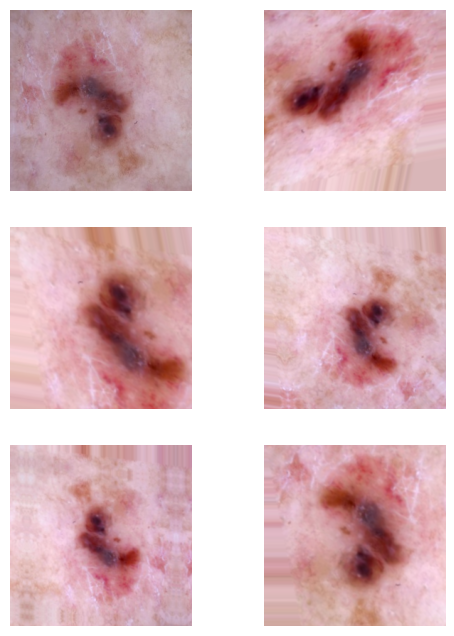

In [ ]:
plt.figure(figsize=(6, 8))
for i, image in enumerate(augm_example_set):
  ax = plt.subplot(3, 2, i + 1)
  plt.imshow(img_to_array(image).astype("uint8"))
  plt.axis("off")

In [ ]:
run_augmentation(data_augmentation, input_dir, output_dir, 2)

In [ ]:
show_dirs_len(output_dir)

.: 2444


In [ ]:
# зберегти за потреби аугментовані зображення
!zip -q -r 2020_train_melanoma_augmented_sub_2.zip . -i /augmented/*
from google.colab import files
files.download("2020_train_melanoma_augmented_sub_2.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# зберегти вибірку без аугментації
!zip -q -r small_subset.zip content/small_subset/
from google.colab import files
files.download("small_subset.zip")


zip error: Nothing to do! (try: zip -q -r 2020_small_subset.zip . -i ./content/small_subset/)


In [ ]:
def add_files(source_dir, dest_dir):
  os.makedirs(dest_dir, exist_ok=True)
  for file_name in os.listdir(source_dir):
    source_file = os.path.join(source_dir, file_name)
    if os.path.isfile(source_file):
      destination_file = os.path.join(dest_dir, file_name)
      shutil.copyfile(source_file, destination_file)

In [ ]:
# додати аугментовані файли у вибірку
add_files(output_dir, input_dir)

In [ ]:
show_dirs_len(input_dir)

.: 3666


In [ ]:
show_dirs_len(subset_path)

.: 3
test: 2
test/melanoma: 1110
test/other: 7446
validation: 2
validation/melanoma: 1018
validation/other: 1018
train: 2
train/melanoma: 3666
train/other: 9328


In [ ]:
# зберегти вибірку з аугментацією цільового класу
# !zip -q -r small_subset_with_augm.zip /content/small_subset
# from google.colab import files
# files.download("small_subset_with_augm.zip")

In [ ]:
# зберегти вибірку з аугментацією цільового класу
!zip -q -r small_subset_with_augm.zip /content/small_subset
from google.colab import files
files.download("small_subset_with_augm.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

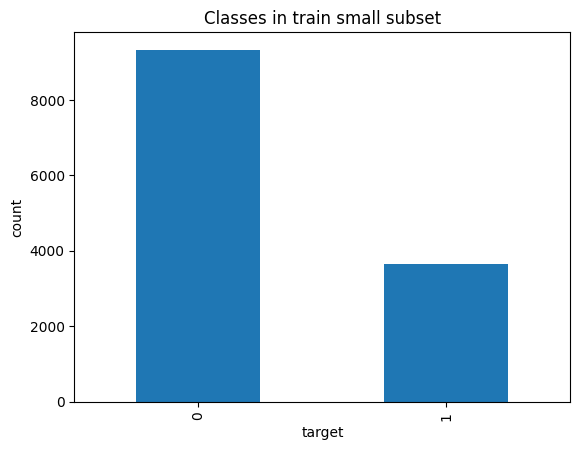

In [ ]:
tmp_df1 = pd.DataFrame({"image_name": os.listdir(subset_path + "/train/melanoma"), "target": 1})
tmp_df2 = pd.DataFrame({"image_name": os.listdir(subset_path + "/train/other"), "target": 0})
tmp_df_comb = pd.concat([tmp_df1, tmp_df2], ignore_index=True)
tmp_df_comb.target.value_counts().plot(kind='bar')
plt.title('Classes in train small subset')
plt.xlabel('target')
plt.ylabel('count')
plt.show()

## Завантаження даних для навчання

In [ ]:
# датасет з аугментацією 1:2
# https://drive.google.com/file/d/1a_KlWRSt82bZDcJDQa18Mf7zwTNNFx6-/view?usp=sharing
file_id = "1a_KlWRSt82bZDcJDQa18Mf7zwTNNFx6-"
url = f"https://drive.google.com/uc?id={file_id}"
output = "small_subset_with_augm.zip"

gdown.download(url, output, quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=1a_KlWRSt82bZDcJDQa18Mf7zwTNNFx6-
From (redirected): https://drive.google.com/uc?id=1a_KlWRSt82bZDcJDQa18Mf7zwTNNFx6-&confirm=t&uuid=42bce34e-4480-4aed-b98f-851b0b386ba1
To: /content/small_subset_with_augm.zip
100%|██████████| 878M/878M [00:12<00:00, 68.2MB/s]


'small_subset_with_augm.zip'

In [ ]:
!unzip -q small_subset_with_augm.zip

In [ ]:
# датасет з аугментацією 1:4
# https://drive.google.com/file/d/1xQm9-q9_e1vNrSZTPBqqSU4MGY5mv3R9/view?usp=sharing
file_id = "1xQm9-q9_e1vNrSZTPBqqSU4MGY5mv3R9"
url = f"https://drive.google.com/uc?id={file_id}"
output = "small_subset_with_augm4.zip"

gdown.download(url, output, quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=1xQm9-q9_e1vNrSZTPBqqSU4MGY5mv3R9
From (redirected): https://drive.google.com/uc?id=1xQm9-q9_e1vNrSZTPBqqSU4MGY5mv3R9&confirm=t&uuid=b18c0e4b-d43b-42eb-86d7-92cda9ff4ded
To: /content/small_subset_with_augm4.zip
100%|██████████| 899M/899M [00:16<00:00, 55.9MB/s]


'small_subset_with_augm4.zip'

In [ ]:
!unzip -q small_subset_with_augm4.zip

In [ ]:
small_data_dir = "/content/content/small_subset"
show_dirs_len(small_data_dir)

.: 3
test: 2
test/melanoma: 1110
test/other: 7446
train: 2
train/melanoma: 6110
train/other: 9328
validation: 2
validation/melanoma: 1018
validation/other: 1018


## Підготовка до навчання

### Визначення параметрів, функцій для побудови моделі

In [ ]:
def generate_model_version_name():

  from datetime import datetime

  now = datetime.now()
  month_day = now.strftime("%m-%d")  # Формат: ММ-ДД
  hours = now.strftime("%H")  # Формат: ЧЧ, тільки години
  return month_day + "-" + hours

In [ ]:
# при дисбалансі класів
def binary_class_weights(dataset):
  count_1 = 0
  count_0 = 0
  for items, labels in dataset:
    labels = labels.numpy()
    count_1 += np.sum(labels==1)
    count_0 += np.sum(labels==0)
  weight_1 = (1/count_1) * ((count_1+count_0)/2.0)
  weight_0 = (1/count_0) * ((count_1+count_0)/2.0)
  return (weight_0, weight_1)

def initial_bias_calc(dataset):
  count_1 = 0
  count_0 = 0
  for items, labels in dataset:
    labels = labels.numpy()
    count_1 += np.sum(labels==1)
    count_0 += np.sum(labels==0)
  weight_1 = (1/count_1) * ((count_1+count_0)/2.0)
  weight_0 = (1/count_0) * ((count_1+count_0)/2.0)
  return np.log([count_1/count_0])


In [ ]:
# при дисбалансі класів при відомій кількості екземплярів кожного класу
def binary_class_weights_2(count_1, count_0):
  weight_1 = (1/count_1) * ((count_1+count_0)/2.0)
  weight_0 = (1/count_0) * ((count_1+count_0)/2.0)
  return (weight_0, weight_1)

def initial_bias_calc_2(count_1, count_0):
  weight_1 = (1/count_1) * ((count_1+count_0)/2.0)
  weight_0 = (1/count_0) * ((count_1+count_0)/2.0)
  return np.log(count_1/count_0)

In [ ]:
# логування
import csv
from tensorflow.keras.callbacks import Callback

# зібрати під час навчання метрики
class MetricsLogger(Callback):
    def __init__(self, filepath):
        super().__init__()
        self.filepath = filepath
        self.metrics = None
        # create file on init
        with open(self.filepath, mode='w', newline='') as f:
            writer = csv.writer(f)
            writer.writerow(['epoch'])
    # method Callbak class
    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        # get logs keys
        if self.metrics is None:
          self.metrics = list(logs.keys())
            # add metrics header to csv
          with open(self.filepath, mode='a', newline='') as f:
              writer = csv.writer(f)
              writer.writerow(['epoch'] + self.metrics)
        with open(self.filepath, mode='a', newline='') as f:
            writer = csv.writer(f)
            writer.writerow([epoch] + [logs[m] for m in self.metrics])

In [ ]:
# візуалізація
def plot_scores (df, model_name, metrics_list):
  n = len(metrics_list)
  fig = plt.figure(figsize=(16, int(np.ceil(n/3)*4) ))
  fig.suptitle(f'{model_name}')
  for i, metric in enumerate(metrics_list):
    ax = plt.subplot(int(np.ceil(n/3)), 3, i + 1)
    ax.plot(df.index+1, df[metric], label=metric)
    ax.plot(df.index+1, df["val_" + metric], label="val_" + metric)
    ax.legend(loc='lower right')
    ax.grid(True)
  fig2 = plt.figure(figsize=(8, 6))
  for i, metric in enumerate(metrics_list):
    plt.plot(df.index+1, df[metric], label=metric)
    plt.plot(df.index+1, df["val_" + metric], label="val_" + metric)
  plt.legend(loc='lower right')
  plt.show();

def plot_loss(df, model_name):
  fig = plt.figure(figsize=(8, 6))
  fig.suptitle(f'{model_name + " loss"}')
  plt.plot(df.index+1, df['loss'], label='train loss')
  plt.plot(df.index+1, df["val_loss"], label="validation loss")
  plt.legend(loc='lower right')
  plt.grid(True)
  plt.show();

In [ ]:
def plot_confusion_matrix(labels, predictions, threshold=0.5):
  cm = confusion_matrix(labels, predictions > threshold)
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["other", "melanoma"])
  disp.plot(cmap=plt.cm.Blues)
  plt.xlabel("Predictions")
  plt.ylabel("Actual")
  plt.title('Confusion matrix')
  plt.show()

In [ ]:
def fbeta_metric(precision, recall, beta=2.0):
  return precision * recall * (1+beta**2)/( (beta**2) * precision + recall)

In [ ]:
# IM_SIZE = 256
BATCH_SIZE = 32
METRICS = [
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR') # precision-recall curve
]
VERSION = generate_model_version_name()
# MODEL_NAME = f"Basic_model_{VERSION}"
LEARNING_RATE = 1e-4

In [ ]:
VERSION

'03-27-17'

### Сворення об'єктів tf.Dataset

In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  small_data_dir + "/train",
  class_names=["other", "melanoma"],
  seed=123,
  # image_size=(IM_SIZE, IM_SIZE),
  shuffle=True,
  batch_size=BATCH_SIZE)

val_ds = tf.keras.utils.image_dataset_from_directory(
  small_data_dir + "/validation",
  class_names=["other", "melanoma"],
  seed=123,
  # image_size=(IM_SIZE, IM_SIZE),
  batch_size=BATCH_SIZE)

test_ds = tf.keras.utils.image_dataset_from_directory(
  small_data_dir + "/test",
  class_names=["other", "melanoma"],
  seed=123,
  # image_size=(IM_SIZE, IM_SIZE),
  batch_size=BATCH_SIZE)

Found 15438 files belonging to 2 classes.
Found 2036 files belonging to 2 classes.
Found 8556 files belonging to 2 classes.


### Візуалізація датасету

In [ ]:
class_names = train_ds.class_names
print(class_names)

In [ ]:
print(train_ds)
print(val_ds)
print(test_ds)

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

### передобробка датасету

In [ ]:
# Configure the dataset for performance
train_ds = train_ds.shuffle(64).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=tf.data.AUTOTUNE)

### ваги класів та initial bias при дисбалансі класів

In [ ]:
count_1 = len(os.listdir(small_data_dir + "/train/melanoma"))
count_0 = len(os.listdir(small_data_dir + "/train/other"))

In [ ]:
# weight_0, weight_1 = binary_class_weights(train_ds)
weight_0, weight_1 = binary_class_weights_2(count_1, count_0)

class_weights = {0: weight_0, 1: weight_1}

print(f'Weight for class 0: {weight_0:.2f}')
print(f'Weight for class 1: {weight_1:.2f}')

Weight for class 0: 0.70
Weight for class 1: 1.77


In [ ]:
# initial_bias = initial_bias_calc(train_ds)
initial_bias = initial_bias_calc_2(count_1, count_0)
print(f'initial_bias: {initial_bias}')

initial_bias: -0.9339194801906233


### Модель

In [ ]:
# створення та компіляція моделі з заданим bias для останнього шару
def make_model(learning_rate=1e-3, metrics=METRICS, model=None, output_bias=None):
  model.compile(
      optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
      loss=keras.losses.BinaryCrossentropy(),
      metrics=metrics)
  if output_bias is not None:
    model.layers[-1].bias.assign([output_bias])
  return model

In [ ]:
MODEL_NAMES = [f"MobileNetV2_{VERSION}",
              f"Xception_{VERSION}",
              f"ResNet50V2_{VERSION}",
              f"InceptionV3_{VERSION}",
               f"ConvNeXtTiny_{VERSION}",
               f"DenseNet121_{VERSION}",
               f"NASNetMobile_{VERSION}",
               f"EfficientNetV2B0_{VERSION}"]

In [ ]:
labels = ['tl-', 'ft-']
label = labels[0]

In [ ]:
model_index = 0
MODEL_NAME = MODEL_NAMES[model_index]

In [ ]:
MODEL_NAME

'MobileNetV2_03-25-20'

In [ ]:
# створити логгер
metrics_logger = MetricsLogger(filepath=f"metrics_logs_{label}{MODEL_NAME}.csv")

In [ ]:
if model_index == 0:
  from keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
  IM_SIZE = 256       #224
  base_model = MobileNetV2(
    weights="imagenet",
    input_shape=(IM_SIZE, IM_SIZE, 3),
    include_top=False)

if model_index == 1:
  from keras.applications.xception import Xception, preprocess_input
  IM_SIZE = 256   #229
  base_model = Xception(
    weights="imagenet",
    input_shape=(IM_SIZE, IM_SIZE, 3),
    include_top=False)

if model_index == 2:
  from keras.applications.resnet_v2 import ResNet50V2, preprocess_input
  IM_SIZE = 256   #224
  base_model = ResNet50V2(
    weights="imagenet",
    input_shape=(IM_SIZE, IM_SIZE, 3),
    include_top=False)

if model_index == 3:
  from keras.applications.inception_v3 import InceptionV3, preprocess_input
  IM_SIZE = 256   #229
  base_model = InceptionV3(
    weights="imagenet",
    input_shape=(IM_SIZE, IM_SIZE, 3),
    include_top=False)

if model_index == 4:
  from keras.applications.convnext import ConvNeXtTiny, preprocess_input
  IM_SIZE = 256
  base_model = ConvNeXtTiny(
    weights="imagenet",
    input_shape=(IM_SIZE, IM_SIZE, 3),
    include_top=False)

if model_index == 5:
  from keras.applications.densenet import DenseNet121, preprocess_input
  IM_SIZE = 256   #224
  base_model = DenseNet121(
    weights="imagenet",
    input_shape=(IM_SIZE, IM_SIZE, 3),
    include_top=False)

if model_index == 6:
  from keras.applications.nasnet import NASNetMobile, preprocess_input
  IM_SIZE = 256    #224
  base_model = NASNetMobile(
    weights="imagenet",
    input_shape=(IM_SIZE, IM_SIZE, 3),
    include_top=False)

if model_index == 7:
  from keras.applications.efficientnet_v2 import EfficientNetV2B0, preprocess_input
  IM_SIZE = 256
  base_model = EfficientNetV2B0(
    weights="imagenet",
    input_shape=(IM_SIZE, IM_SIZE, 3),
    include_top=False)

print(base_model.output_shape)

# preprocess for fine_tuning:
def preprocess(image, label):
  image = preprocess_input(image)
  return image, label

<ipython-input-30-02062533dda3>:4: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
(None, 8, 8, 1280)


In [ ]:
# заморозити шари базової моделі
base_model.trainable = False

In [ ]:
# train_ds = train_ds.map(preprocess)
# val_ds = val_ds.map(preprocess)
# test_ds = test_ds.map(preprocess)

In [ ]:
# модель
inputs = keras.Input(shape=(IM_SIZE, IM_SIZE, 3))
preprocessed = layers.Lambda(preprocess_input)(inputs)
x = base_model(preprocessed, training=False)  #to keep batchnorm layers in inference mode, when unfreeze the base model for fine-tuning
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.5)(x)
x = keras.layers.Dense(128, activation='relu', name="full_con1")(x)
outputs = keras.layers.Dense(1, activation='sigmoid', name="pred")(x)
model = keras.Model(inputs, outputs)

# Навчання та оцінка

### MobileNetV2

### Feature extraction

In [ ]:
MODEL_NAME

'MobileNetV2_03-25-20'

In [ ]:
# створення та компіляція transfer learning моделі
ft_model = make_model(metrics=METRICS, model=model, output_bias=initial_bias)
model.summary(show_trainable=True)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━┓
┃ Layer (type)                        ┃ Output Shape                 ┃       Param # ┃ Traina… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━┩
│ input_layer_1 (InputLayer)          │ (None, 256, 256, 3)          │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ lambda (Lambda)                     │ (None, 256, 256, 3)          │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ mobilenetv2_1.00_224 (Functional)   │ (None, 8, 8, 1280)           │     2,257,984 │    N    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ global_average_pooling2d            │ (None, 1280)                 │             0 │    -    │
│ (GlobalAveragePooling2D)            │                              │               │         │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ dropout (Dropout)                   │ (None, 1280)                 │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ full_con1 (Dense)                   │ (None, 128)                  │       163,968 │    Y    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ pred (Dense)                        │ (None, 1)                    │           129 │    Y    │
└─────────────────────────────────────┴──────────────────────────────┴───────────────┴─────────┘

 Total params: 2,422,081 (9.24 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:
callbacks_list = [EarlyStopping(monitor='val_accuracy', patience=6),
                  ModelCheckpoint(f'small-{label}{MODEL_NAME}.keras', monitor='val_loss', save_best_only=True),
                  metrics_logger,
                  WandbMetricsLogger(),
                  WandbModelCheckpoint(filepath=f"small-{label}{MODEL_NAME}_wandb.keras", monitor="val_loss")
]

epochs=20

In [ ]:
# MobileNetV2
history = ft_model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=callbacks_list,
  class_weight=class_weights
)

Epoch 1/20
407/407 ━━━━━━━━━━━━━━━━━━━━ 50s 86ms/step - accuracy: 0.9114 - auc: 0.9578 - fbeta: 0.8609 - fn: 199.0662 - fp: 329.4044 - loss: 0.2464 - prc: 0.9277 - precision: 0.8147 - recall: 0.8734 - tn: 4375.9116 - tp: 1637.3334 - val_accuracy: 0.8728 - val_auc: 0.9527 - val_fbeta: 0.8203 - val_fn: 209.0000 - val_fp: 50.0000 - val_loss: 0.2972 - val_prc: 0.9580 - val_precision: 0.9418 - val_recall: 0.7947 - val_tn: 968.0000 - val_tp: 809.0000
Epoch 2/20
407/407 ━━━━━━━━━━━━━━━━━━━━ 22s 49ms/step - accuracy: 0.9390 - auc: 0.9789 - fbeta: 0.9056 - fn: 157.0319 - fp: 237.1544 - loss: 0.1754 - prc: 0.9647 - precision: 0.8768 - recall: 0.9132 - tn: 4457.8164 - tp: 1690.4485 - val_accuracy: 0.8806 - val_auc: 0.9582 - val_fbeta: 0.8365 - val_fn: 189.0000 - val_fp: 54.0000 - val_loss: 0.2752 - val_prc: 0.9637 - val_precision: 0.9388 - val_recall: 0.8143 - val_tn: 964.0000 - val_tp: 829.0000
Epoch 3/20
407/407 ━━━━━━━━━━━━━━━━━━━━ 40s 50ms/step - accuracy: 0.9431 - auc: 0.9823 - fbeta: 0.9140

In [ ]:
from google.colab import files

df_basic = pd.DataFrame(history.history)
df_basic.to_csv(f"metrics_{label}{MODEL_NAME}.csv", index=False)

files.download(f'/content/metrics_logs_{label}{MODEL_NAME}.csv')
files.download(f'/content/small-{label}{MODEL_NAME}.keras')
files.download(f'/content/metrics_{label}{MODEL_NAME}.csv')

# metrics_filepath = f"/content/metrics_{label}{MODEL_NAME}.csv"
# df_basic = pd.read_csv(metrics_filepath)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

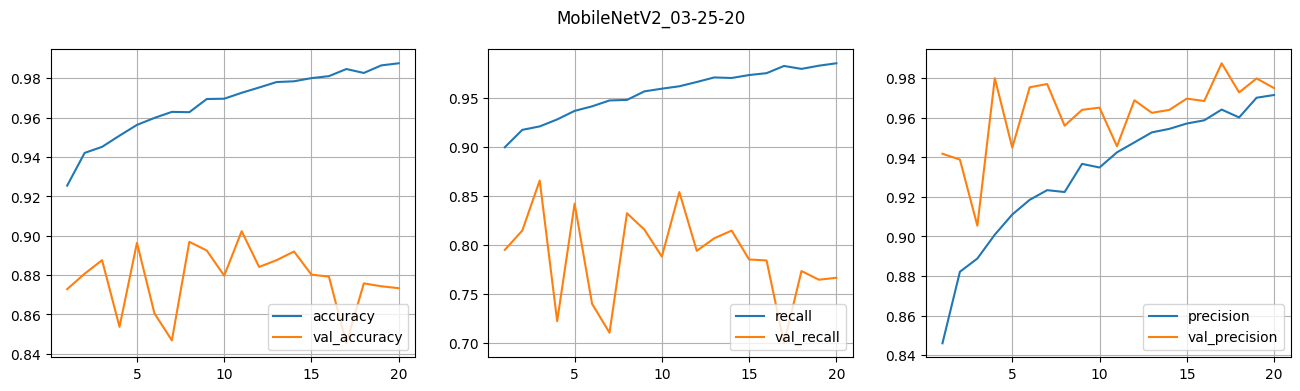

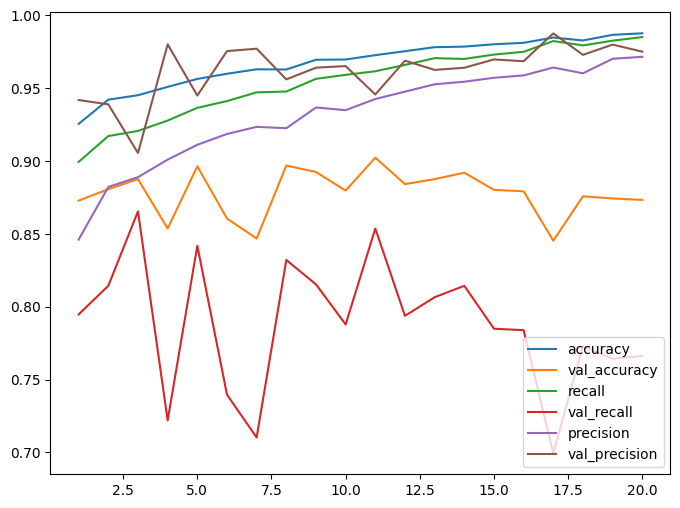

In [ ]:
# MobileNetV2
plot_scores (df_basic, MODEL_NAME, ['accuracy', 'recall', 'precision'])

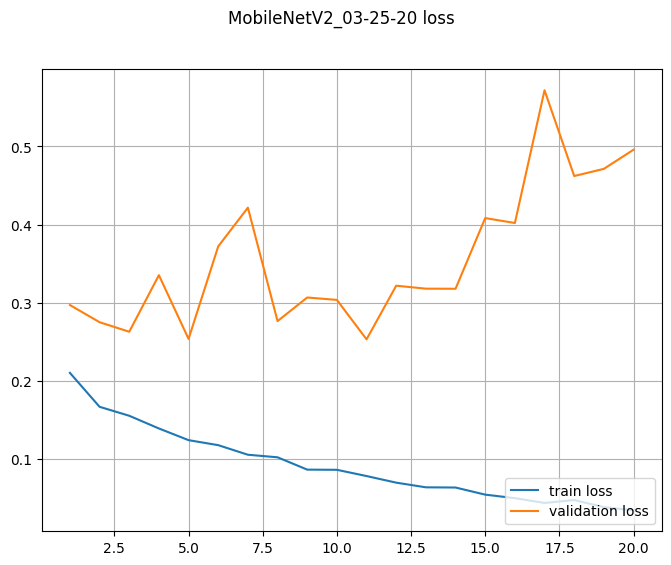

In [ ]:
# MobileNetV2
plot_loss(df_basic, MODEL_NAME)

In [ ]:

model_path = f"/content/small-{label}{MODEL_NAME}.keras"
best_tl_model = keras.models.load_model(model_path, custom_objects={"preprocess_input": preprocess_input})

In [ ]:
best_tl_results = best_tl_model.evaluate(test_ds, verbose=1)

268/268 ━━━━━━━━━━━━━━━━━━━━ 18s 66ms/step - accuracy: 0.9171 - auc: 0.9560 - fbeta: 0.7915 - fn: 84.1078 - fp: 280.4833 - loss: 0.2061 - prc: 0.8720 - precision: 0.6288 - recall: 0.8469 - tn: 3489.3643 - tp: 465.7769
loss :  0.21163684129714966
compile_metrics :  0.9160822629928589



In [ ]:
for name, value in zip(best_tl_model.metrics_names, best_tl_results):
  print(name, ': ', value)
print()

loss :  0.21163684129714966
compile_metrics :  0.9160822629928589



In [ ]:
precision = best_tl_results[1]
recall = best_tl_results[2]
fbeta = fbeta_metric(precision, recall)
best_tl_results.append(fbeta)

In [ ]:
for name, value in zip(["loss"] + [m.name for m in METRICS] + ["f1_beta"], best_tl_results):
  print(name, ': ', value)
print()

loss :  0.21163684129714966
<BinaryAccuracy name=accuracy> :  0.9160822629928589
<Precision name=precision> :  0.6308411359786987
<Recall name=recall> :  0.8513513803482056
<FBetaScore name=fbeta> :  0.7957225441932678
<TruePositives name=tp> :  945.0
<FalsePositives name=fp> :  553.0
<TrueNegatives name=tn> :  6893.0
<FalseNegatives name=fn> :  165.0
<AUC name=auc> :  0.9574875235557556
<AUC name=prc> :  0.8690258264541626



In [ ]:
# Зберегти результат оцінки на тествому наборі
df_eval = pd.DataFrame({'Metric': ["loss"] + METRICS + ["f1_beta"], 'Value': best_tl_results})
df_eval.to_csv(f'evaluate_results_{label}{MODEL_NAME}.csv', index=False)
files.download(f'/content/evaluate_results_{label}{MODEL_NAME}{MODEL_NAME}.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# !rm -rf wandb/ ~/.wandb /tmp/wandb

### Fine tuning

In [ ]:
MODEL_NAME

'MobileNetV2_03-27-10'

In [ ]:
labels = ['tl-', 'ft-']
label = labels[1]

In [ ]:
from google.colab import files
files.upload()

In [ ]:
model_path = f"/content/small-tl-{MODEL_NAME}.keras"
best_tl_model = keras.models.load_model(model_path, custom_objects={"preprocess_input": preprocess_input})

In [ ]:
base_model = best_tl_model.get_layer('mobilenetv2_1.00_224')

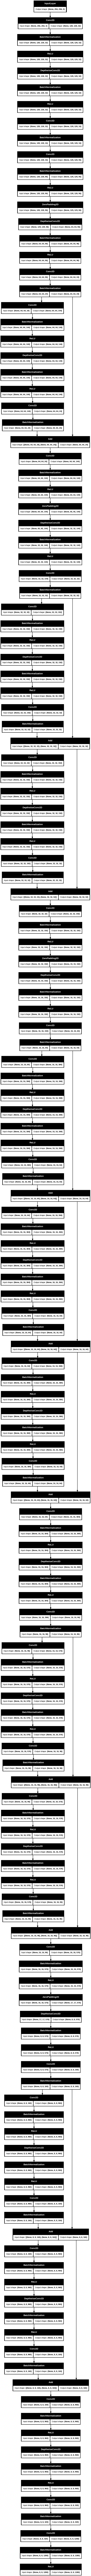

In [ ]:
plot_model(base_model, show_shapes=True)

In [ ]:
for layer in base_model.layers[-20:]:
  layer.trainable=True

for layer in base_model.layers[:-20]:
  layer.trainable=False

In [ ]:
best_tl_model.summary(show_trainable=True)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━┓
┃ Layer (type)                        ┃ Output Shape                 ┃       Param # ┃ Traina… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━┩
│ input_layer_1 (InputLayer)          │ (None, 256, 256, 3)          │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ lambda (Lambda)                     │ (None, 256, 256, 3)          │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ mobilenetv2_1.00_224 (Functional)   │ (None, 8, 8, 1280)           │     2,257,984 │    N    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ global_average_pooling2d            │ (None, 1280)                 │             0 │    -    │
│ (GlobalAveragePooling2D)            │                              │               │         │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ dropout (Dropout)                   │ (None, 1280)                 │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ full_con1 (Dense)                   │ (None, 128)                  │       163,968 │    Y    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ pred (Dense)                        │ (None, 1)                    │           129 │    Y    │
└─────────────────────────────────────┴──────────────────────────────┴───────────────┴─────────┘

 Total params: 2,750,277 (10.49 MB)

 Trainable params: 1,370,177 (5.23 MB)

 Non-trainable params: 1,051,904 (4.01 MB)

 Optimizer params: 328,196 (1.25 MB)

In [ ]:
best_tl_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-5),
    loss=keras.losses.BinaryCrossentropy(),
    metrics=METRICS)

In [ ]:
callbacks_list = [EarlyStopping(monitor='val_accuracy', patience=6),
                  ModelCheckpoint(f'small-{label}{MODEL_NAME}.keras', monitor='val_loss', save_best_only=True),
                  metrics_logger,
                  WandbMetricsLogger(),
                  WandbModelCheckpoint(filepath=f"small-{label}{MODEL_NAME}_wandb.keras", monitor="val_loss")
]

epochs=20

In [ ]:
# MobileNetV2 fine tuning
history = best_tl_model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=callbacks_list,
  class_weight=class_weights
)

Epoch 1/20
407/407 ━━━━━━━━━━━━━━━━━━━━ 61s 95ms/step - accuracy: 0.8852 - auc: 0.9607 - fbeta: 0.8778 - fn: 154.4510 - fp: 499.6324 - loss: 0.3310 - prc: 0.9040 - precision: 0.7402 - recall: 0.9228 - tn: 4214.7036 - tp: 1673.4436 - val_accuracy: 0.8856 - val_auc: 0.9601 - val_fbeta: 0.8328 - val_fn: 197.0000 - val_fp: 36.0000 - val_loss: 0.3168 - val_prc: 0.9671 - val_precision: 0.9580 - val_recall: 0.8065 - val_tn: 982.0000 - val_tp: 821.0000
Epoch 2/20
407/407 ━━━━━━━━━━━━━━━━━━━━ 53s 49ms/step - accuracy: 0.9393 - auc: 0.9802 - fbeta: 0.9103 - fn: 149.7647 - fp: 249.1446 - loss: 0.1810 - prc: 0.9608 - precision: 0.8690 - recall: 0.9213 - tn: 4461.1567 - tp: 1683.3407 - val_accuracy: 0.8718 - val_auc: 0.9547 - val_fbeta: 0.8000 - val_fn: 238.0000 - val_fp: 23.0000 - val_loss: 0.4018 - val_prc: 0.9633 - val_precision: 0.9714 - val_recall: 0.7662 - val_tn: 995.0000 - val_tp: 780.0000
Epoch 3/20
407/407 ━━━━━━━━━━━━━━━━━━━━ 21s 49ms/step - accuracy: 0.9529 - auc: 0.9891 - fbeta: 0.9265

In [ ]:
# from google.colab import files

df_basic = pd.DataFrame(history.history)
df_basic.to_csv(f"metrics_{label}{MODEL_NAME}.csv", index=False)

files.download(f'/content/metrics_logs_{label}{MODEL_NAME}.csv')
files.download(f'/content/small-{label}{MODEL_NAME}.keras')
files.download(f'/content/metrics_{label}{MODEL_NAME}.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

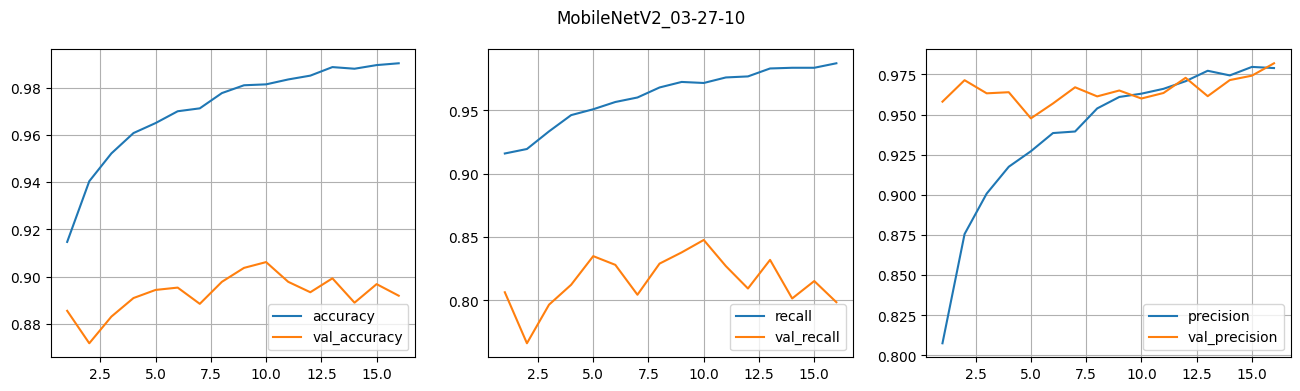

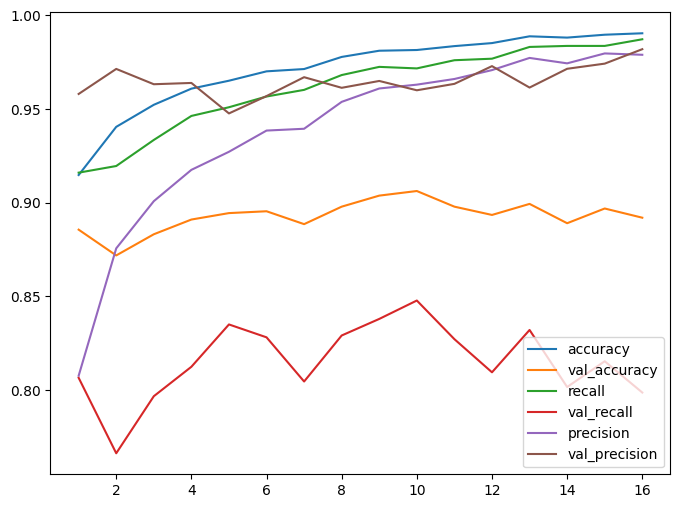

In [ ]:
plot_scores (df_basic, MODEL_NAME, ['accuracy', 'recall', 'precision'])

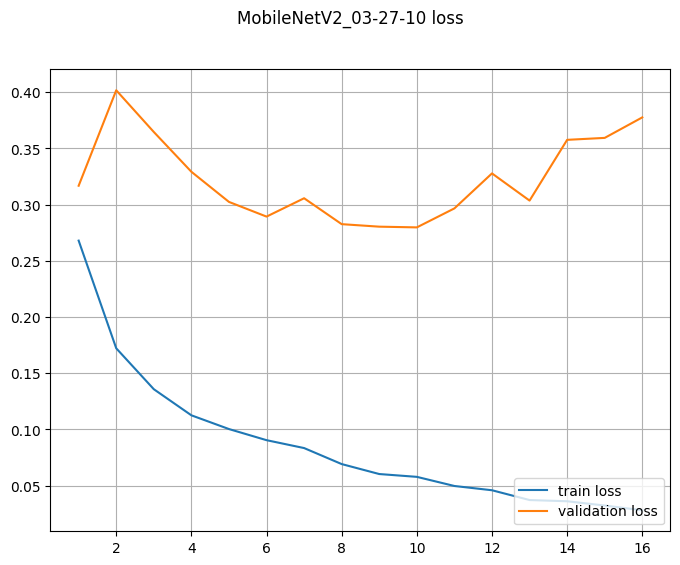

In [ ]:
plot_loss(df_basic, MODEL_NAME)

In [ ]:
# load best model after fine tuning
model_path = f"/content/small-ft-{MODEL_NAME}.keras"
best_ft_model = keras.models.load_model(model_path, custom_objects={"preprocess_input": preprocess_input})

In [ ]:
best_ft_results = best_ft_model.evaluate(test_ds, verbose=1)

268/268 ━━━━━━━━━━━━━━━━━━━━ 28s 81ms/step - accuracy: 0.9351 - auc: 0.9548 - fbeta: 0.8170 - fn: 82.1152 - fp: 209.9591 - loss: 0.1927 - prc: 0.8805 - precision: 0.7003 - recall: 0.8528 - tn: 3558.3345 - tp: 469.3234


In [ ]:
precision = best_ft_results[1]
recall = best_ft_results[2]
fbeta = fbeta_metric(precision, recall)
best_ft_results.append(fbeta)

In [ ]:
for metric, value in zip(["loss"] + [m.name for m in METRICS] + ["f1_beta"], best_ft_results):
  print(metric, ': ', value)
print()

loss :  0.1917123794555664
accuracy :  0.9332631826400757
precision :  0.6980161666870117
recall :  0.8558558821678162
fbeta :  0.8188244104385376
tp :  950.0
fp :  411.0
tn :  7035.0
fn :  160.0
auc :  0.957641065120697
prc :  0.8782067894935608



In [ ]:
# Зберегти результат оцінки на тествому наборі
df_eval = pd.DataFrame({'Metric': ["loss"] + [m.name for m in METRICS] + ["f1_beta"], 'Value': best_ft_results})
df_eval.to_csv(f'evaluate_results_{label}{MODEL_NAME}.csv', index=False)
files.download(f'/content/evaluate_results_{label}{MODEL_NAME}.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
predictions_array = []
test_labels_array = []
for images, labels in test_ds:
    predictions = best_ft_model.predict(images, verbose=0)
    predictions_array.extend(predictions)
    test_labels_array.extend(labels.numpy())
predictions_array = np.array(predictions_array)
test_labels_array = np.array(test_labels_array)

In [ ]:
plot_confusion_matrix(test_labels_array, predictions_array, threshold=0.5)